Link to dataset: https://www.kaggle.com/datasets/rabieelkharoua/parkinsons-disease-dataset-analysis

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

**Data Preprocessing Part 1**

In [4]:
#Open Dataset
parkinsons_data = pd.read_csv('parkinsons_disease_data.csv')
print(parkinsons_data.shape)
parkinsons_data.head()

(2105, 35)


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis,DoctorInCharge
0,3058,85,0,3,1,19.619878,0,5.108241,1.380660,3.893969,...,1.572427,1,0,0,0,0,0,0,0,DrXXXConfid
1,3059,75,0,0,2,16.247339,1,6.027648,8.409804,8.513428,...,4.787551,0,1,0,1,0,1,0,1,DrXXXConfid
2,3060,70,1,0,0,15.368239,0,2.242135,0.213275,6.498805,...,2.130686,1,0,0,0,1,0,1,1,DrXXXConfid
3,3061,52,0,0,0,15.454557,0,5.997788,1.375045,6.715033,...,3.391288,1,1,1,0,0,0,1,1,DrXXXConfid
4,3062,87,0,0,1,18.616042,0,9.775243,1.188607,4.657572,...,3.200969,0,0,0,1,0,1,0,0,DrXXXConfid


In [5]:
# Drop Irrelevant Features and Features That Already Identify Parkinsons (ie, UPDRS, MoCA, FunctionalAssessment)
pk_irr = parkinsons_data.drop('PatientID',axis=1)
pk_irr = pk_irr.drop('DoctorInCharge',axis=1)
pk_irr = pk_irr.drop('UPDRS',axis=1)
pk_irr = pk_irr.drop('MoCA',axis=1)
pk_irr = pk_irr.drop('FunctionalAssessment',axis=1)

In [6]:
########################## Function for Anomaly Removal ###########################
def remove_anomalies(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    LB = Q1 - (IQR*1.5)
    UB = Q3 + (IQR*1.5)
    return (data - data[(data[feature]< LB) | (data[feature] > UB)])
###################################################################################

In [7]:
# Decouple Features and Target
pk_features = pk_irr.drop('Diagnosis',axis=1)
pk_target = pk_irr['Diagnosis']

In [8]:
# Apply SMOTE for class imbalance correction
smote = SMOTE()
pk_x_smote, pk_y_smote = smote.fit_resample(pk_features, pk_target)

**Data Visualization**

In [10]:
# Custom Palette For Visualizations
palette = {0: 'green', 1: 'red'}

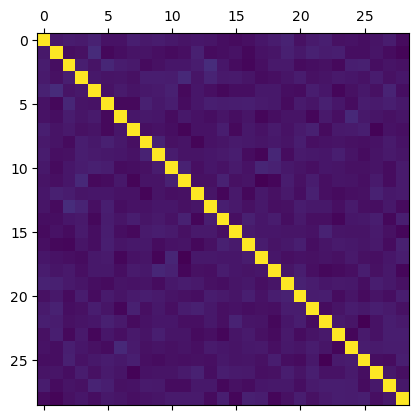

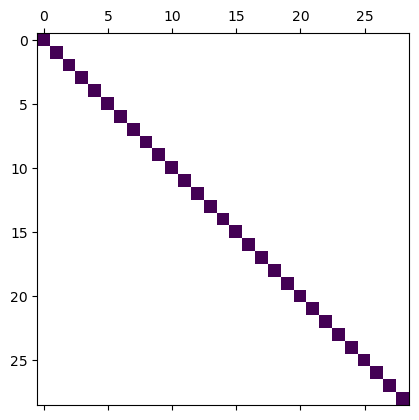

In [11]:
# Visualize Correlation
data_correlation = pk_features.corr()
data_high_correlation = data_correlation[abs(data_correlation) >= 0.5]
plt.matshow(data_correlation)
plt.matshow(data_high_correlation)

The above heatmap shows that none of the features in this dataset have a correlation above the cutoff we chose, which was 0.5. Therefore, there was no need to remove any features on account of correlation.

Diagnosis
1    1304
0     801
Name: count, dtype: int64


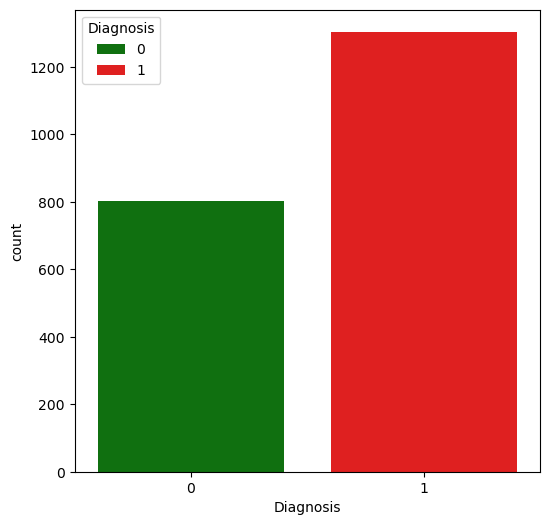

In [13]:
#Visualize Original Class Imbalance
print(pk_irr['Diagnosis'].value_counts())
plt.figure(figsize=(6, 6))
sns.countplot(x='Diagnosis', data=pk_irr, hue='Diagnosis', palette=palette)
plt.show()

There was a considerable class imbalance; most of the data points in the dataset were of the positive class (patients with parkinsons). This was corrected by applying SMOTE.

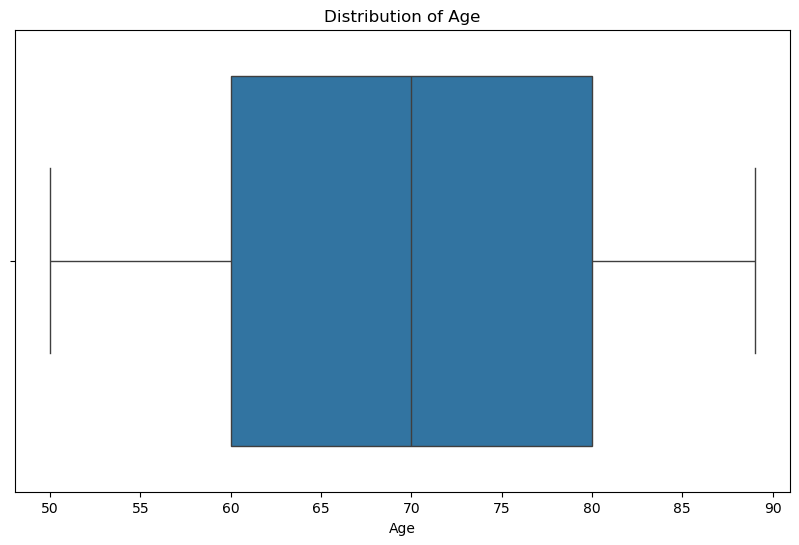

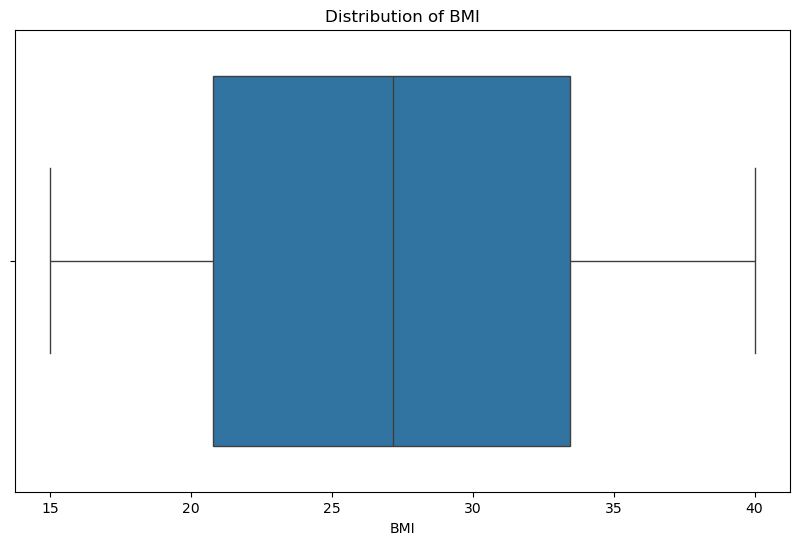

In [15]:
# Box Plots
plt.figure(figsize=(10, 6))

# Create a box plot for 'Age'
sns.boxplot(x=parkinsons_data['Age'])
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.show()

# Create a box plot for 'BMI'
plt.figure(figsize=(10, 6))
sns.boxplot(x=parkinsons_data['BMI'])
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.show()

As you can see above, the distribution of age box plot lies between 60 and 80 years. The distribution of BMI box plots lies between 20 and 35 BMI values

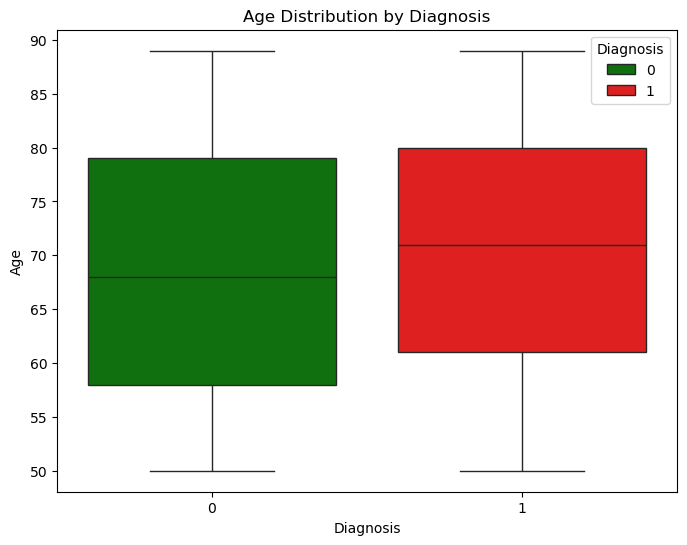

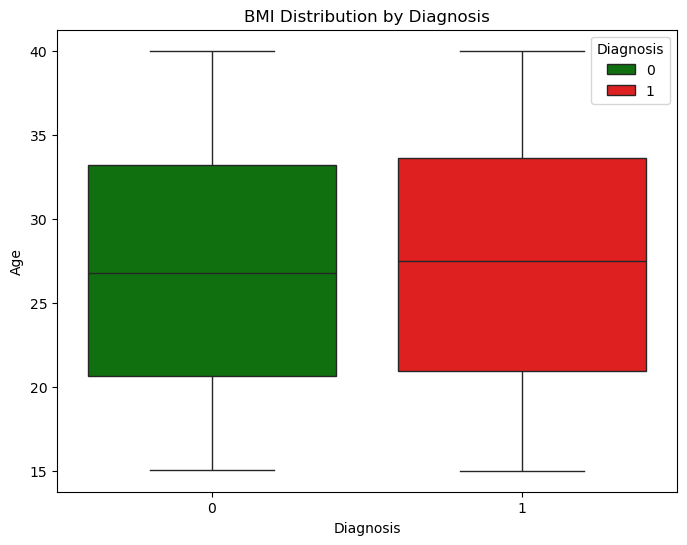

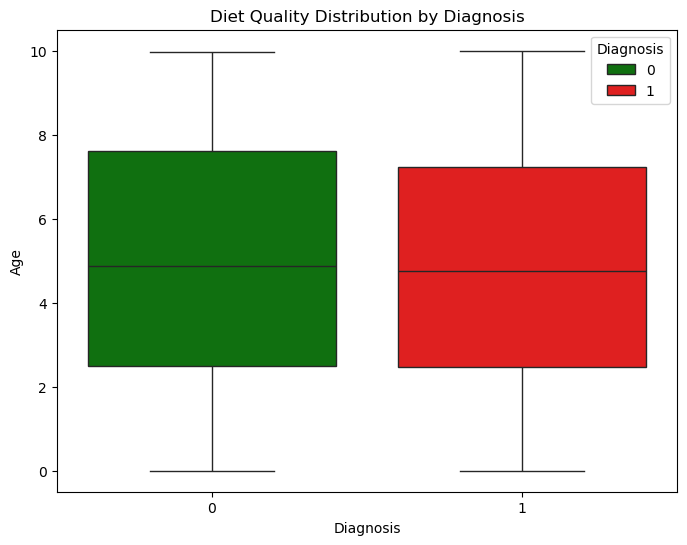

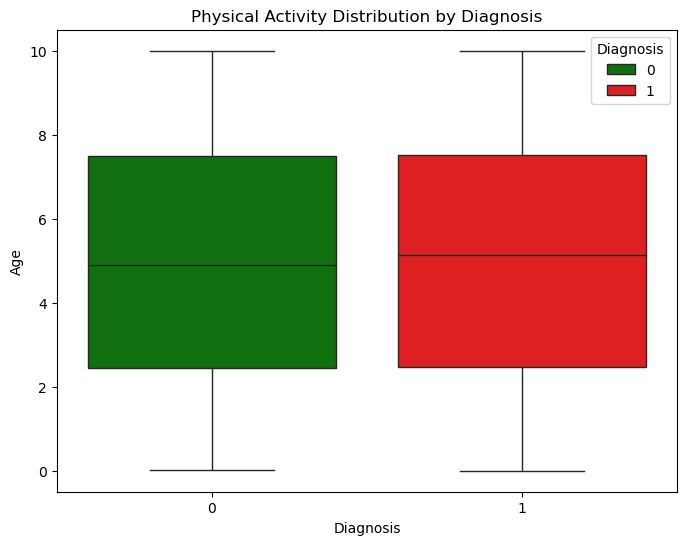

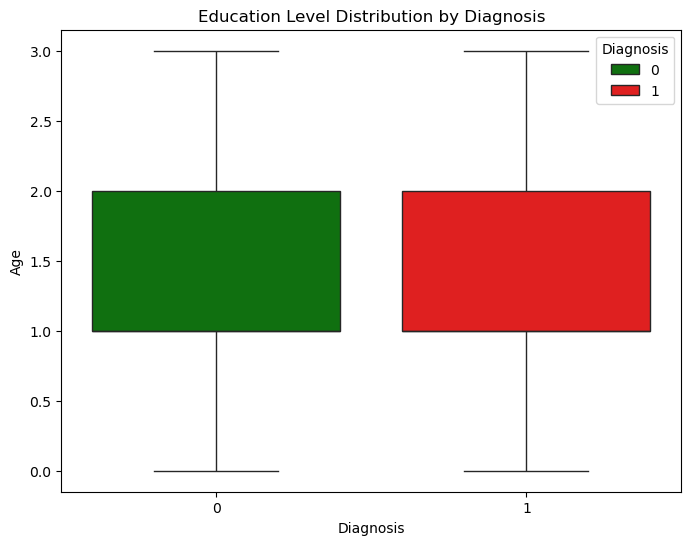

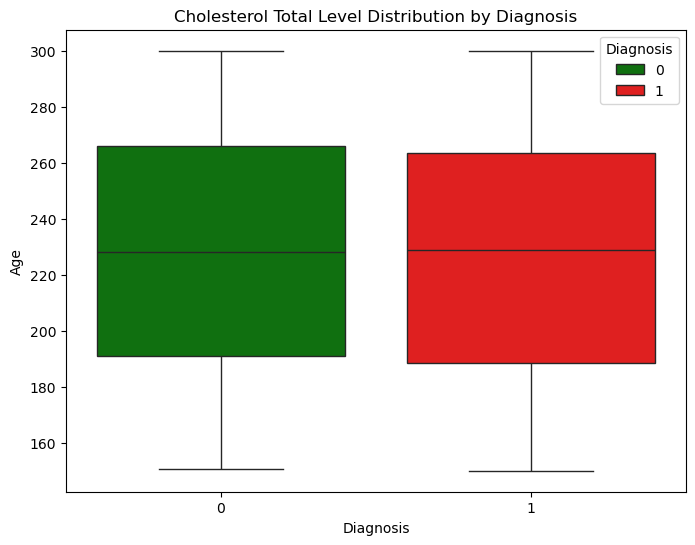

In [17]:
#Box Plots Separated By Class
def side_by_side_boxplots(data, column, title, ylabel):
    
    # Create the boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Diagnosis', y=column, data=data, hue='Diagnosis', palette={1: 'red', 0: 'green'})
    plt.title(title)
    plt.xlabel('Diagnosis')
    plt.ylabel(ylabel)
    plt.show()

side_by_side_boxplots(pk_irr, 'Age', 'Age Distribution by Diagnosis', 'Age')
side_by_side_boxplots(pk_irr, 'BMI', 'BMI Distribution by Diagnosis', 'Age')
side_by_side_boxplots(pk_irr, 'DietQuality', 'Diet Quality Distribution by Diagnosis', 'Age')
side_by_side_boxplots(pk_irr, 'PhysicalActivity', 'Physical Activity Distribution by Diagnosis', 'Age')
side_by_side_boxplots(pk_irr, 'EducationLevel', 'Education Level Distribution by Diagnosis', 'Age')
side_by_side_boxplots(pk_irr, 'CholesterolTotal', 'Cholesterol Total Level Distribution by Diagnosis', 'Age')

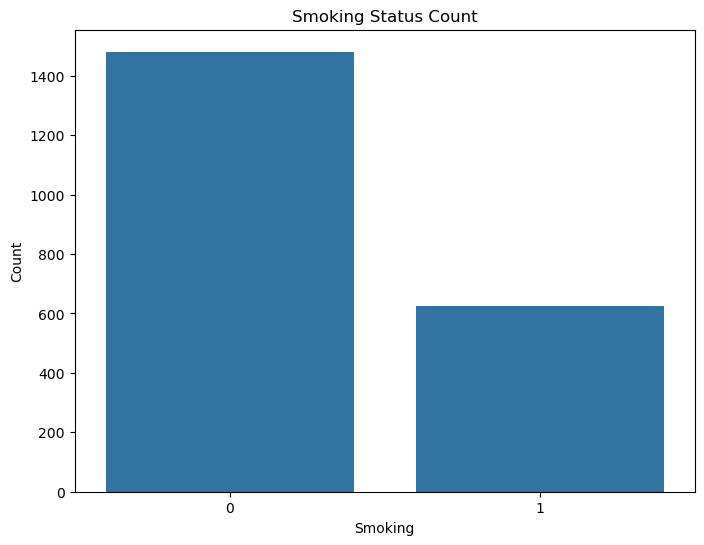

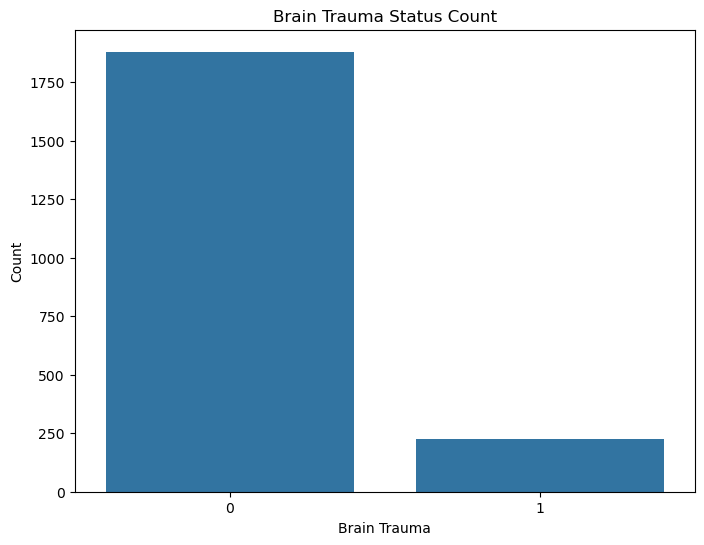

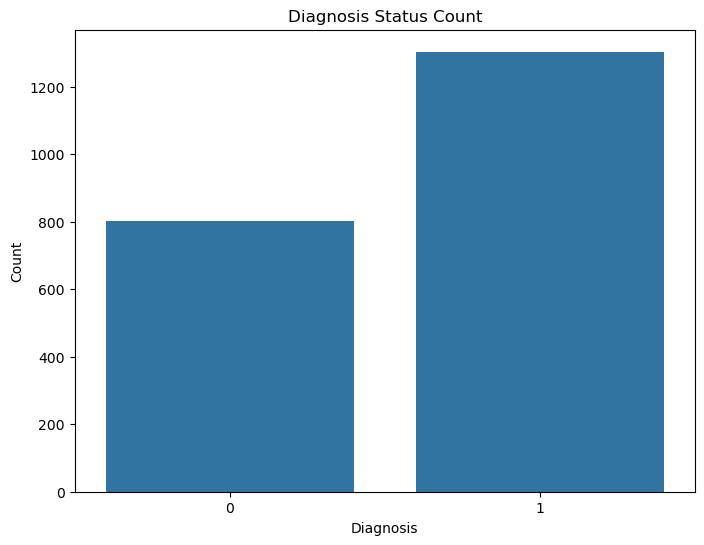

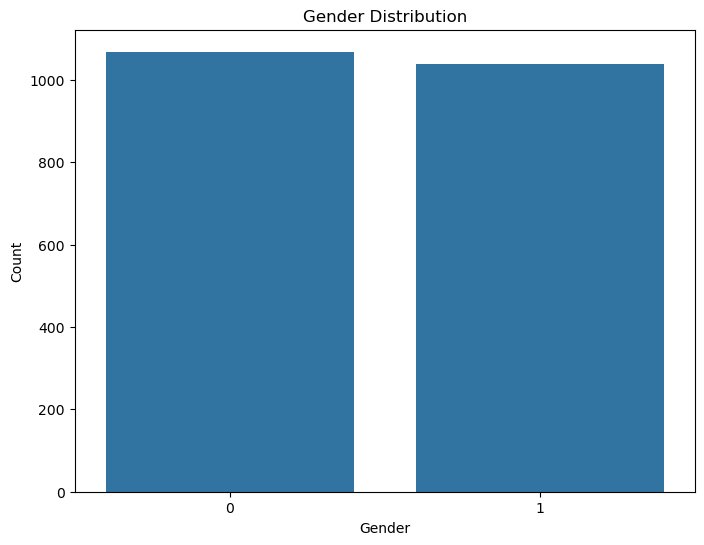

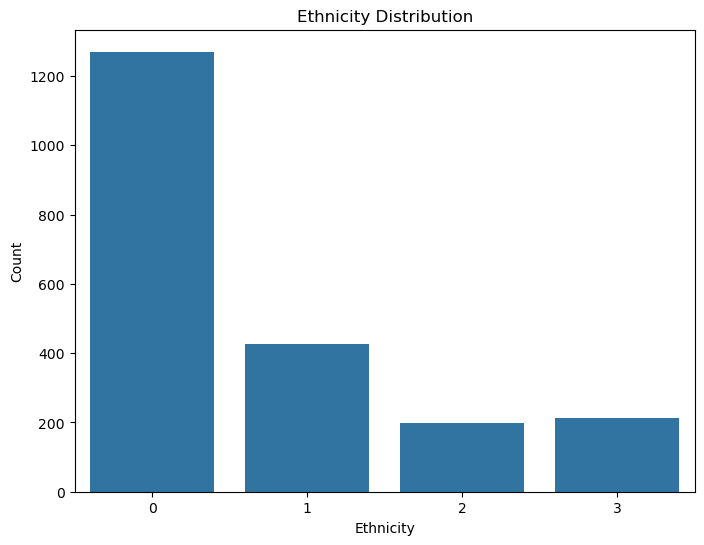

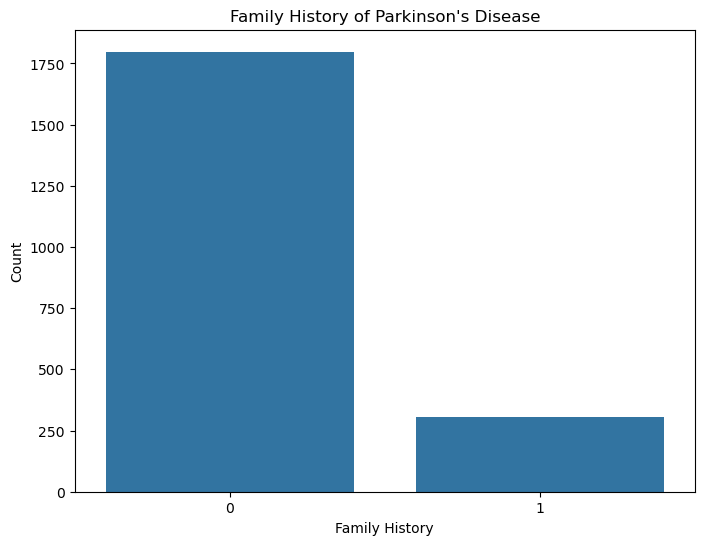

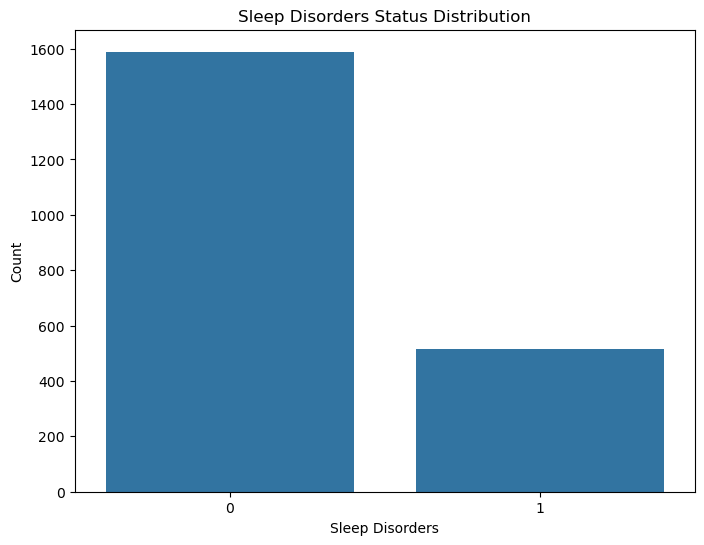

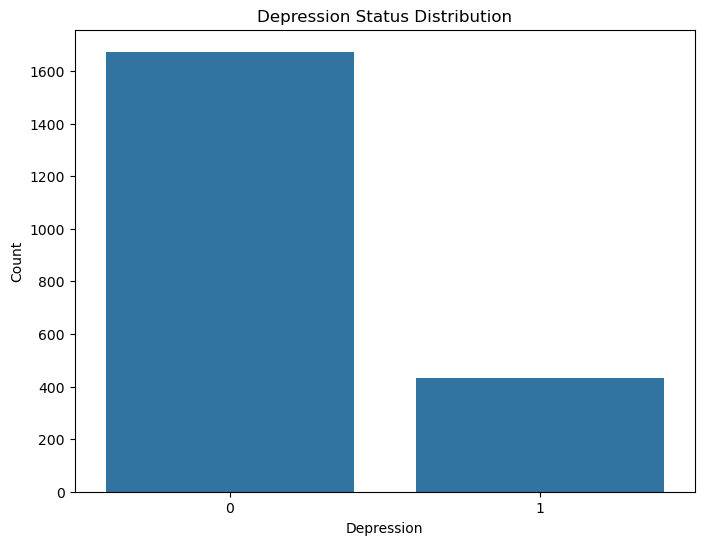

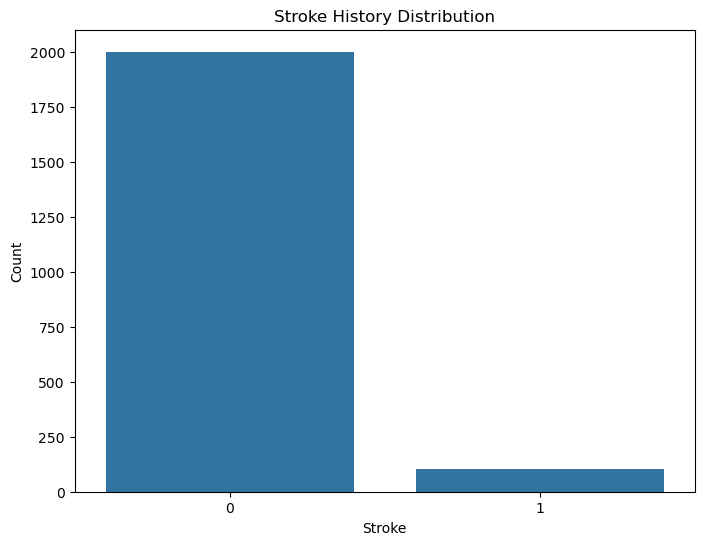

In [18]:
# Bar Graphs
def plot_categorical_counts(df, column, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_categorical_counts(parkinsons_data, 'Smoking', 'Smoking Status Count', 'Smoking', 'Count')
# Plotting the count of people with brain trauma (Assuming 'BrainTrauma' column exists)
plot_categorical_counts(parkinsons_data, 'TraumaticBrainInjury', 'Brain Trauma Status Count', 'Brain Trauma', 'Count')

# Plotting the diagnosis count (assuming 'Diagnosis' column exists, typically binary 0 or 1)
plot_categorical_counts(parkinsons_data, 'Diagnosis', 'Diagnosis Status Count', 'Diagnosis', 'Count')

# Plotting the distribution of gender in the dataset (0 = Male, 1 = Female)
plot_categorical_counts(parkinsons_data, 'Gender', 'Gender Distribution', 'Gender', 'Count')

# Plotting the distribution of ethnicity in the dataset (0 = Caucasian, 1 = African American, 2 = Asian, 3 = Other)
plot_categorical_counts(parkinsons_data, 'Ethnicity', 'Ethnicity Distribution', 'Ethnicity', 'Count')

# Plotting the distribution of family history of Parkinson’s Disease (0 = No, 1 = Yes)
plot_categorical_counts(parkinsons_data, 'FamilyHistoryParkinsons', 'Family History of Parkinson\'s Disease', 'Family History', 'Count')

# Plotting the distribution of sleep disorders status (0 = No, 1 = Yes)
plot_categorical_counts(parkinsons_data, 'SleepDisorders', 'Sleep Disorders Status Distribution', 'Sleep Disorders', 'Count')

# Plotting the distribution of depression status (0 = No, 1 = Yes)
plot_categorical_counts(parkinsons_data, 'Depression', 'Depression Status Distribution', 'Depression', 'Count')

# Plotting the distribution of stroke history (0 = No, 1 = Yes)
plot_categorical_counts(parkinsons_data, 'Stroke', 'Stroke History Distribution', 'Stroke', 'Count')


Smoking Status Count Graph:
The graph shows that the majority of the individuals in the dataset are non-smokers (represented by 0), with significantly fewer individuals identified as smokers (represented by 1).

Brain Trauma Status Count Graph:
This graph indicates that most individuals in the dataset have not had brain trauma (represented by 0), with a small proportion of individuals who have experienced brain trauma (represented by 1).

Diagnosis Status Count:
The dataset shows a higher number of individuals diagnosed with Parkinson’s disease (represented by 1), compared to those not diagnosed (represented by 0).

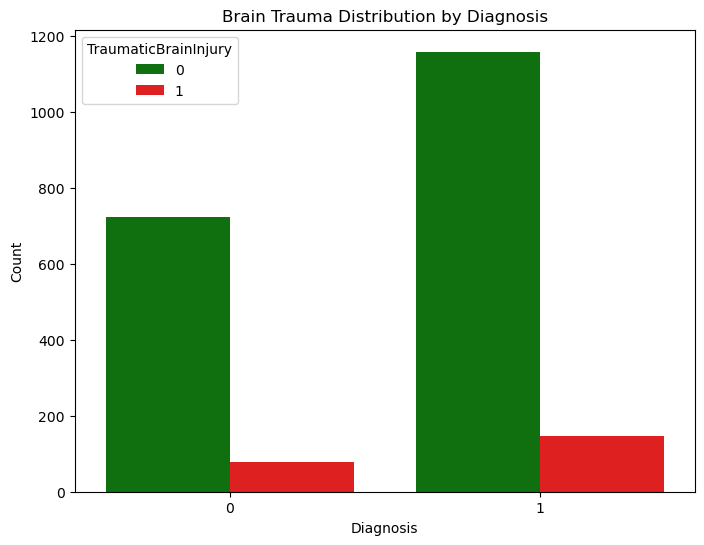

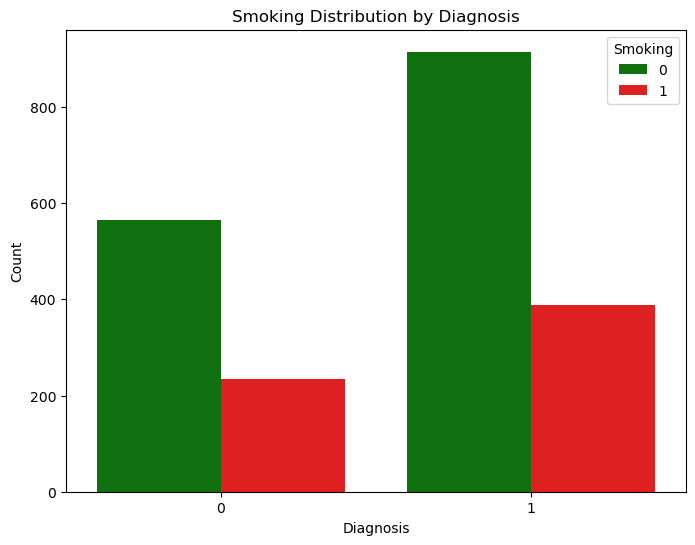

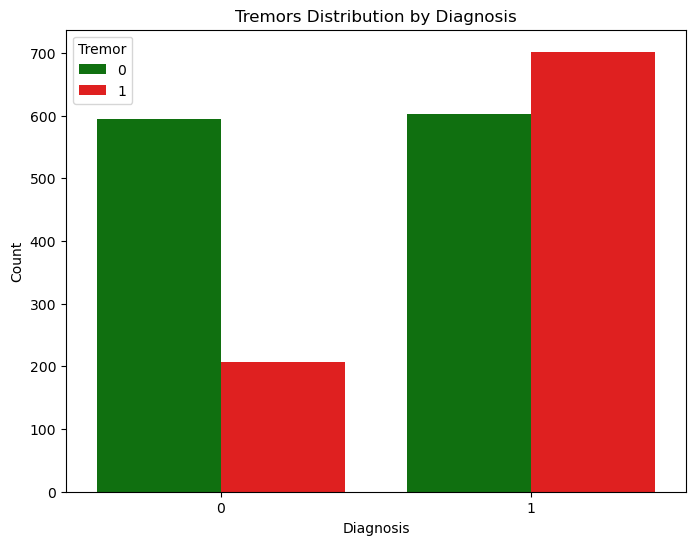

In [20]:
def side_by_side_barplots(data, column, title, ylabel):
    # Group data by Diagnosis and the specified column, counting occurrences
    grouped_data = data.groupby(['Diagnosis', column]).size().reset_index(name='Count')
    
    # Create the bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x='Diagnosis', 
        y='Count', 
        hue=column,  # Split bars by the feature (e.g., BrainTrauma)
        data=grouped_data, 
        palette={0: 'green', 1: 'red'}  # Customize colors for 0 and 1
    )
    plt.title(title)
    plt.xlabel('Diagnosis')
    plt.ylabel(ylabel)
    plt.legend(title=column)
    plt.show()

# Example usage
side_by_side_barplots(pk_irr, 'TraumaticBrainInjury', 'Brain Trauma Distribution by Diagnosis', 'Count')
side_by_side_barplots(pk_irr, 'Smoking', 'Smoking Distribution by Diagnosis', 'Count')
side_by_side_barplots(pk_irr, 'Tremor', 'Tremors Distribution by Diagnosis', 'Count')

**Data Preprocessing Part 2**

In [22]:
#Scale Data
standard_scale = StandardScaler()
st_pk_x = standard_scale.fit_transform(pk_x_smote)

In [23]:
#Split Training and Testing Set
x_train, x_test, y_train, y_test = train_test_split(st_pk_x, pk_y_smote, train_size=.8, random_state=42)

**Feature Selection**

In [25]:
#Iterative Forward Feature Selection
#Using Logistic Regression as a base
feature_model = LogisticRegression(random_state=42)

f_sel =  SequentialFeatureSelector(estimator=feature_model, n_features_to_select="auto", direction="backward", scoring="f1", cv=3)
f_sel.fit(x_train, y_train)

#Take best features from this training and use for all future models
top_features = f_sel.support_
x_train_s = x_train[:, top_features]
x_test_s = x_test[:, top_features]

#Retrieve Feature Names For Plotting
feature_names = pk_features.columns.tolist()
selected_feature_names = [name for name, selected in zip(feature_names, f_sel.support_) if selected]

In [26]:
selected_feature_names

['Gender',
 'BMI',
 'Smoking',
 'AlcoholConsumption',
 'FamilyHistoryParkinsons',
 'TraumaticBrainInjury',
 'Hypertension',
 'Depression',
 'CholesterolTotal',
 'Tremor',
 'Rigidity',
 'Bradykinesia',
 'PosturalInstability',
 'SpeechProblems',
 'Constipation']

These are the 20 features the above feature elimination process has selected as the most important.

**First Model Implementation - Simple Logistic Regression**

In [29]:
#Fit Model
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train_s, y_train)

#Fit Model w/o Feature Selection for comparison
logreg_b = LogisticRegression(random_state=42)
logreg_b.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [30]:
#Make Predictions
logreg_pred = logreg.predict(x_test_s)
logreg_b_pred = logreg_b.predict(x_test)

**First Model Evaluation - Simple Logistic Regression**

With Feature Selection:
Accuracy: 0.735632183908046
Precision: 0.7444444444444445
Recall: 0.7444444444444445
f1: 0.7444444444444445


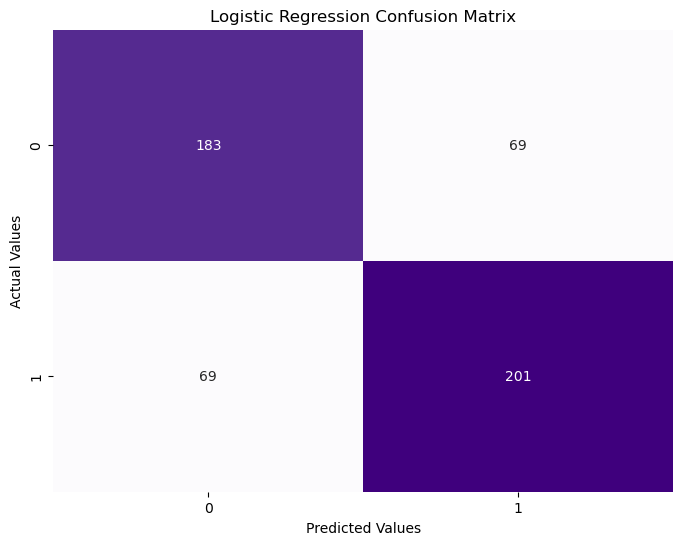


Without Feature Selection:
Accuracy: 0.7528735632183908
Precision: 0.7701149425287356
Recall: 0.7444444444444445
f1: 0.7570621468926554


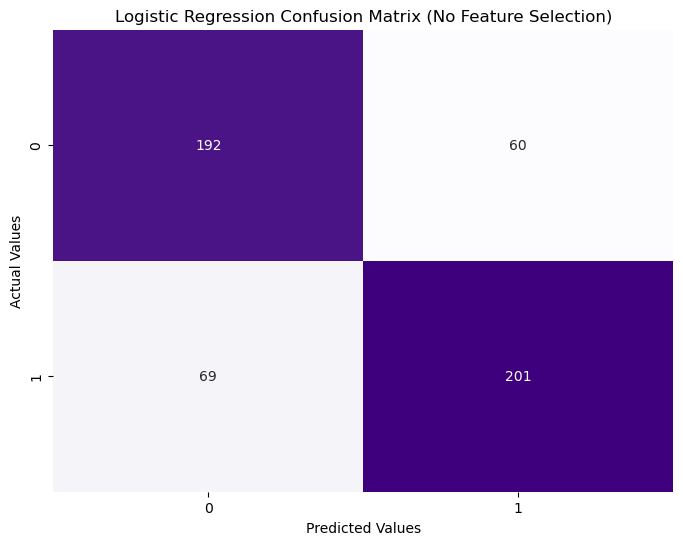

In [32]:
#With Feature Selection
lr_accuracy = accuracy_score(y_test, logreg_pred)
lr_precision = precision_score(y_test, logreg_pred)
lr_recall = recall_score(y_test, logreg_pred)
lr_f1 = f1_score(y_test, logreg_pred)
lr_confusion_matrix = confusion_matrix(y_test, logreg_pred)
print("With Feature Selection:")
print("Accuracy: " + str(lr_accuracy))
print("Precision: " + str(lr_precision))
print("Recall: " + str(lr_recall))
print("f1: " + str(lr_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(lr_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

#Without Feature Selection
lr_b_accuracy = accuracy_score(y_test, logreg_b_pred)
lr_b_precision = precision_score(y_test, logreg_b_pred)
lr_b_recall = recall_score(y_test, logreg_b_pred)
lr_b_f1 = f1_score(y_test, logreg_b_pred)
lr_b_confusion_matrix = confusion_matrix(y_test, logreg_b_pred)
print("\nWithout Feature Selection:")
print("Accuracy: " + str(lr_b_accuracy))
print("Precision: " + str(lr_b_precision))
print("Recall: " + str(lr_b_recall))
print("f1: " + str(lr_b_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(lr_b_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression Confusion Matrix (No Feature Selection)')
plt.show()

**First Model Visualization - Simple Logistic Regression**

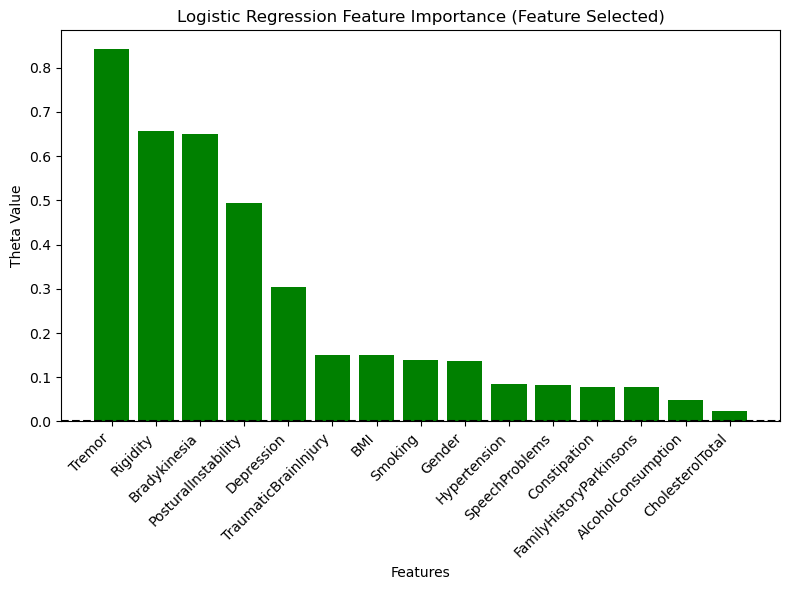

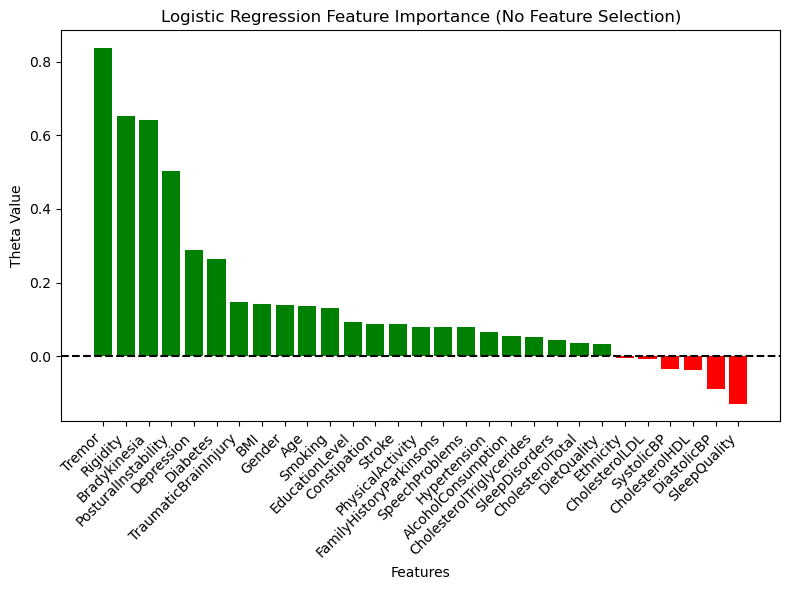

In [34]:
#With Feature Selection
logreg_thetas = pd.DataFrame({"Feature": selected_feature_names, "Thetas": logreg.coef_[0]}).sort_values(by="Thetas", ascending=False)
logreg_b_thetas =pd.DataFrame({"Feature": feature_names, "Thetas": logreg_b.coef_[0]}).sort_values(by="Thetas", ascending=False)

logreg_colors = ["green" if coef > 0 else "red" for coef in logreg_thetas["Thetas"]]
plt.figure(figsize=(8, 6))
plt.bar(logreg_thetas["Feature"], logreg_thetas["Thetas"], color=logreg_colors)
plt.axhline(0, color='black', linestyle='--')
plt.title("Logistic Regression Feature Importance (Feature Selected)")
plt.xlabel("Features")
plt.ylabel("Theta Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

logreg_b_colors = ["green" if coef > 0 else "red" for coef in logreg_b_thetas["Thetas"]]
plt.figure(figsize=(8, 6))
plt.bar(logreg_b_thetas["Feature"], logreg_b_thetas["Thetas"], color=logreg_b_colors)
plt.axhline(0, color='black', linestyle='--')
plt.title("Logistic Regression Feature Importance (No Feature Selection)")
plt.xlabel("Features")
plt.ylabel("Theta Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

These visualizations reveal huge influence from symptom features- notably, tremor, rigidity, bradykinesia, and depression. All other features seem to be decently important in determination of diagnosis in our linear models, except for Ethnicity and LDL Cholesterol as shown by the above graph in the model which is *not* feature selected.

**Second Model Implementation - SVM With Gaussian Kernel**

In [37]:
#Fit Model with Optimal Parameters Using GridSearchCV
svm_params = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]}
svm = GridSearchCV(estimator=SVC(kernel='rbf', random_state=42), param_grid=svm_params, scoring='f1', cv=5)
svm.fit(x_train_s, y_train)

#Fit Model w/o Feature Selection for comparison
svm_b = GridSearchCV(estimator=SVC(kernel='rbf', random_state=42), param_grid=svm_params, scoring='f1', cv=5)
svm_b.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]},
             scoring='f1')

In [38]:
#Make Predictions
svm_pred = svm.predict(x_test_s)
svm_b_pred = svm_b.predict(x_test)

**Second Model Evaluation - SVM With Gaussian Kernel**

With Feature Selection:
Accuracy: 0.7394636015325671
Precision: 0.7133757961783439
Recall: 0.8296296296296296
F1 Score: 0.7671232876712328


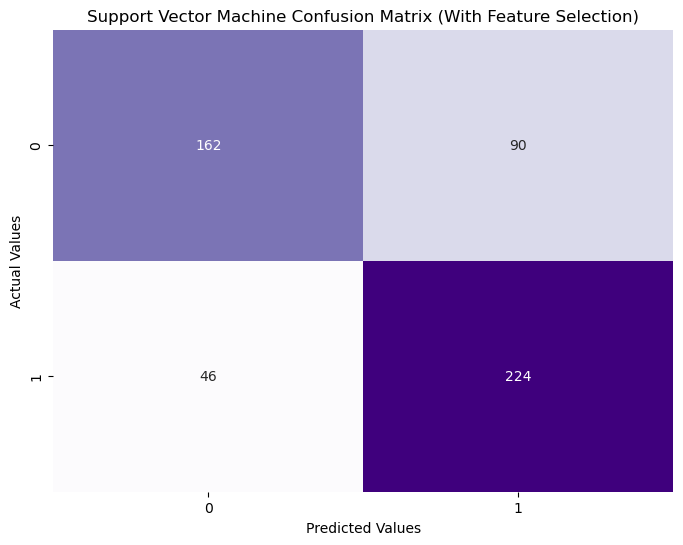


Without Feature Selection:
Accuracy: 0.7528735632183908
Precision: 0.7169230769230769
Recall: 0.8629629629629629
F1 Score: 0.7831932773109244


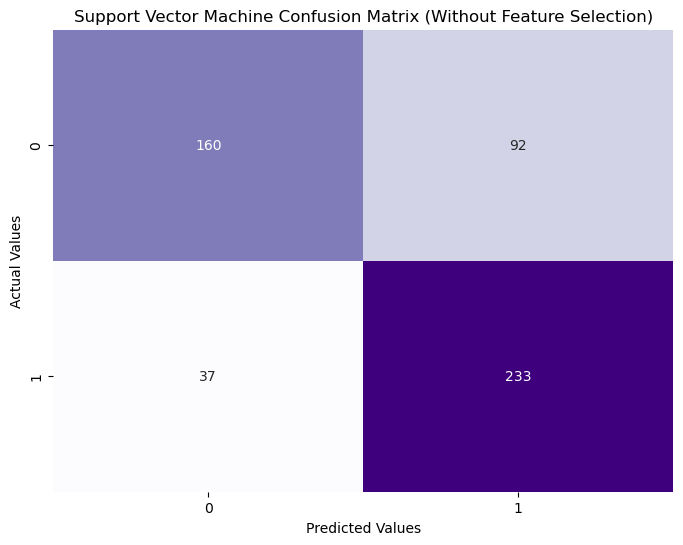

In [40]:
# With Feature Selection
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_confusion_matrix = confusion_matrix(y_test, svm_pred)
print("With Feature Selection:")
print("Accuracy: " + str(svm_accuracy))
print("Precision: " + str(svm_precision))
print("Recall: " + str(svm_recall))
print("F1 Score: " + str(svm_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(svm_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Support Vector Machine Confusion Matrix (With Feature Selection)')
plt.show()

# Without Feature Selection
svm_b_accuracy = accuracy_score(y_test, svm_b_pred)
svm_b_precision = precision_score(y_test, svm_b_pred)
svm_b_recall = recall_score(y_test, svm_b_pred)
svm_b_f1 = f1_score(y_test, svm_b_pred)
svm_b_confusion_matrix = confusion_matrix(y_test, svm_b_pred) 
print("\nWithout Feature Selection:")
print("Accuracy: " + str(svm_b_accuracy))
print("Precision: " + str(svm_b_precision))
print("Recall: " + str(svm_b_recall))
print("F1 Score: " + str(svm_b_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(svm_b_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Support Vector Machine Confusion Matrix (Without Feature Selection)')
plt.show()

This model does not appear to benefit from the feature selection technique used in logistic regression; in fact, removing features slightly reduces its performance. Since Gaussian Kernel SVMs leverage dimensionality, this makes sense from a theoretical standpoint.

**Second Model Visualization - SVM With Gaussian Kernel (TODO)**

Insert something here

**Third Model Implementation - Decision Tree**

In [45]:
#NOTE OUTPUT PARAMETERS AND ANALYZE
#Fit Decision Tree with Optimal Parameters Using GridSearchCV
dt_params = {'max_depth': [5, 10, 15, None], 'criterion': ['gini', 'entropy'],'min_samples_split': [5, 10], 'min_samples_leaf': [1, 2, 4]}
dtree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=dt_params, scoring='f1', cv=5)
dtree_b = copy.deepcopy(dtree)
dtree.fit(x_train_s, y_train)
dtree_b.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10]},
             scoring='f1')

In [46]:
#Make Predictions
dt_pred = dtree.predict(x_test_s)
dt_b_pred = dtree_b.predict(x_test)

**Third Model Evaluation - Decision Tree**

With Feature Selection:
Accuracy: 0.7471264367816092
Precision: 0.7169811320754716
Recall: 0.8444444444444444
F1 Score: 0.7755102040816326


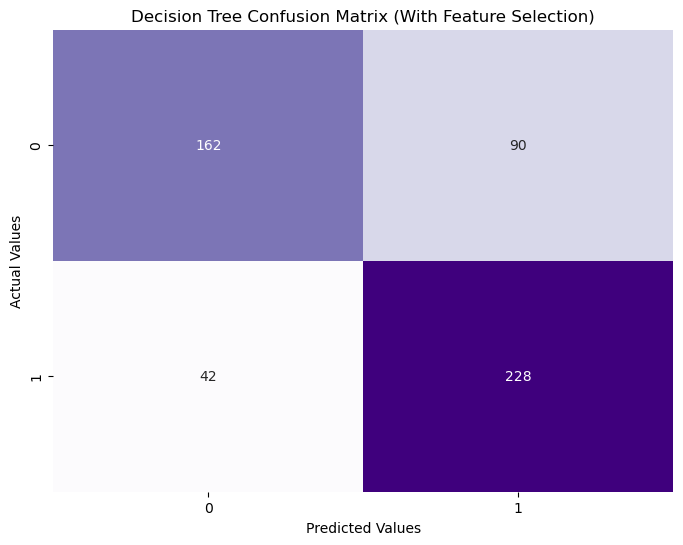


Without Feature Selection:
Accuracy: 0.7452107279693486
Precision: 0.7216828478964401
Recall: 0.825925925925926
F1 Score: 0.770293609671848


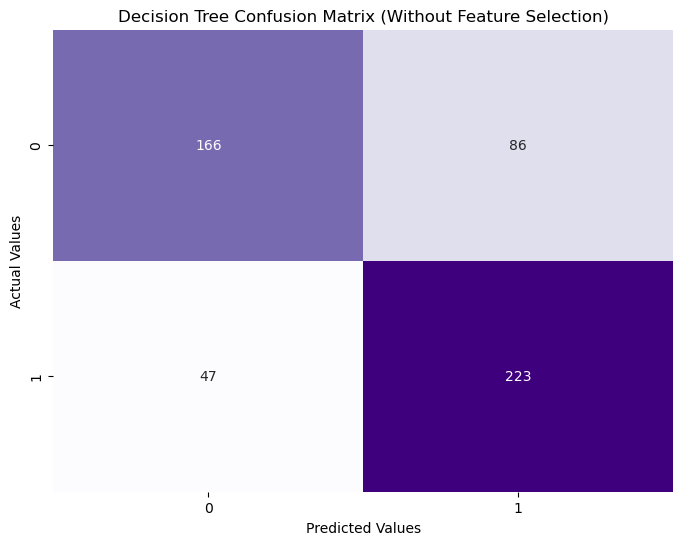

In [48]:
# With Feature Selection
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_confusion_matrix = confusion_matrix(y_test, dt_pred)
print("With Feature Selection:")
print("Accuracy: " + str(dt_accuracy))
print("Precision: " + str(dt_precision))
print("Recall: " + str(dt_recall))
print("F1 Score: " + str(dt_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(dt_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Decision Tree Confusion Matrix (With Feature Selection)')
plt.show()

#Without Feature Selection
dt_b_accuracy = accuracy_score(y_test, dt_b_pred)
dt_b_precision = precision_score(y_test, dt_b_pred)
dt_b_recall = recall_score(y_test, dt_b_pred)
dt_b_f1 = f1_score(y_test, dt_b_pred)
dt_b_confusion_matrix = confusion_matrix(y_test, dt_b_pred) 
print("\nWithout Feature Selection:")
print("Accuracy: " + str(dt_b_accuracy))
print("Precision: " + str(dt_b_precision))
print("Recall: " + str(dt_b_recall))
print("F1 Score: " + str(dt_b_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(dt_b_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Decision Tree Confusion Matrix (Without Feature Selection)')
plt.show()

Feature selection appears to only slightly affect the tree's performance. This is likely because decision trees inherently select the most important features during training, making them less reliant on a pre-filtered feature set.

**Third Model Visualization - Decision Tree**

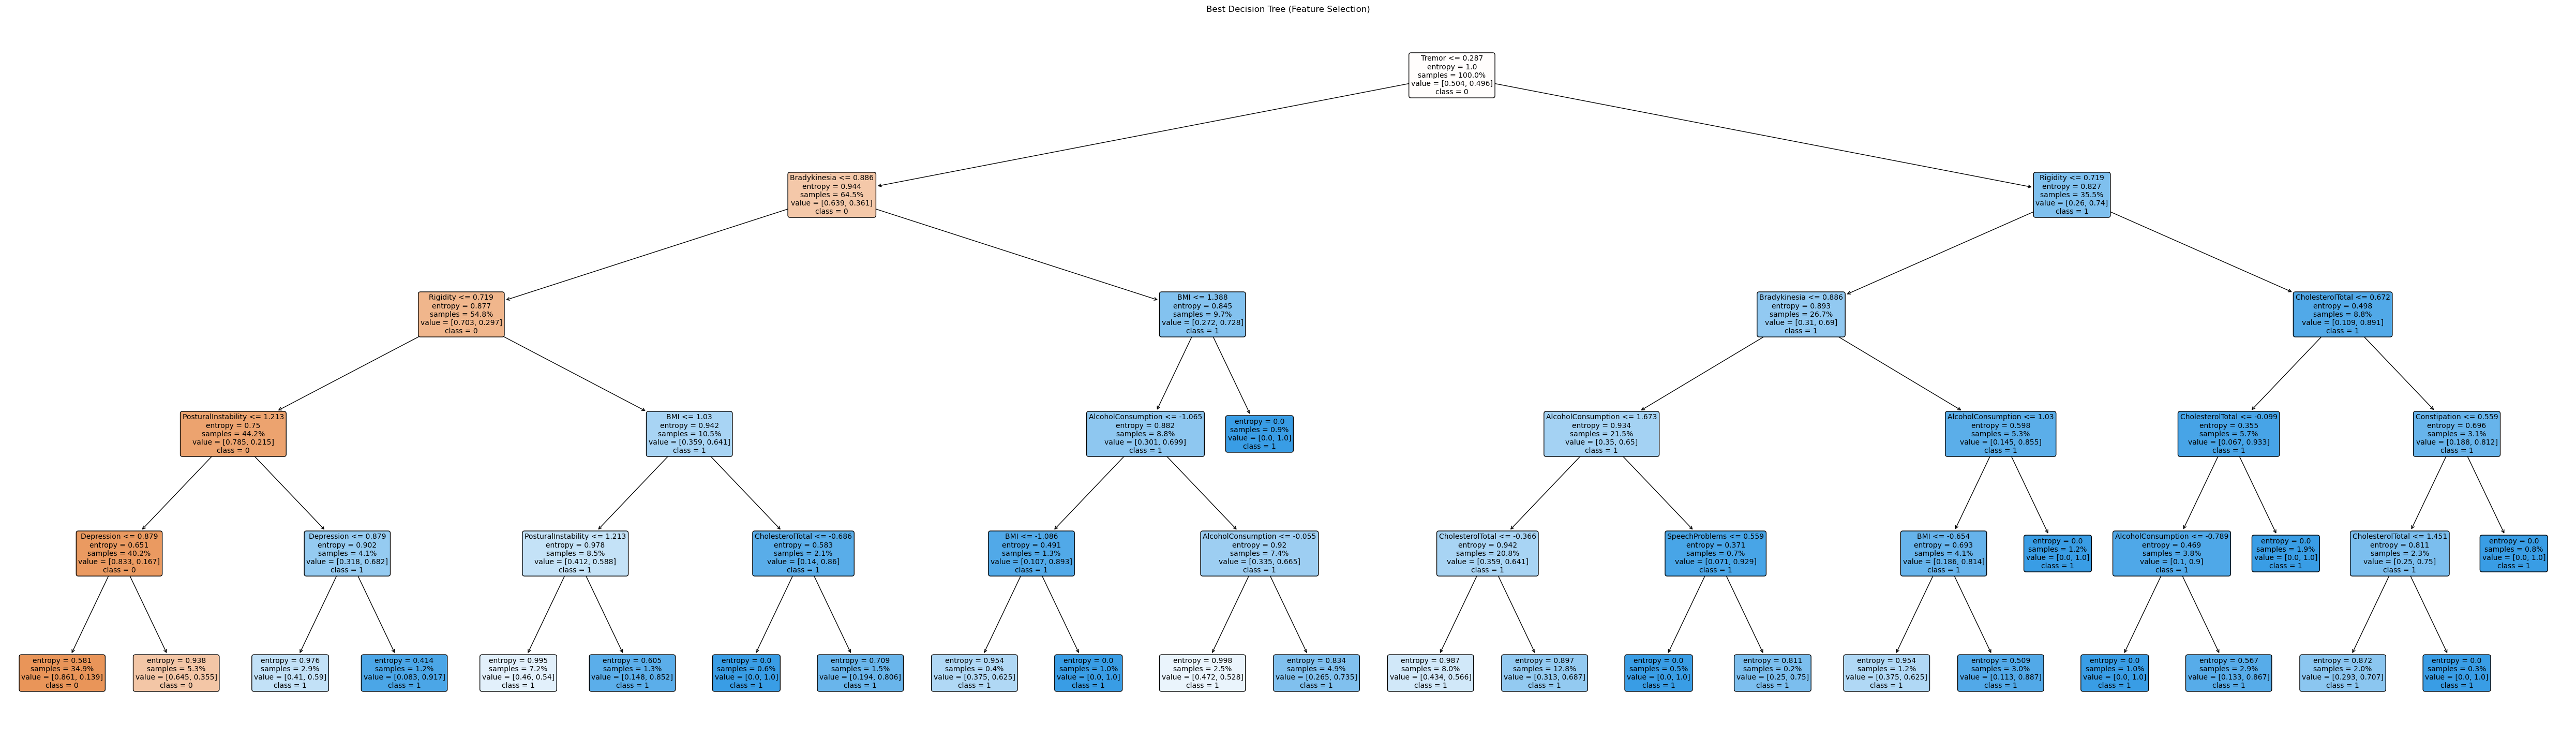

In [51]:
#Show Tree With Feature Selection Applied
plt.figure(figsize=(64, 18))
plot_tree(dtree.best_estimator_, feature_names=selected_feature_names, class_names=["0", "1"], filled=True, rounded=True, proportion=True, fontsize=10)
plt.title("Best Decision Tree (Feature Selection)")
plt.show()

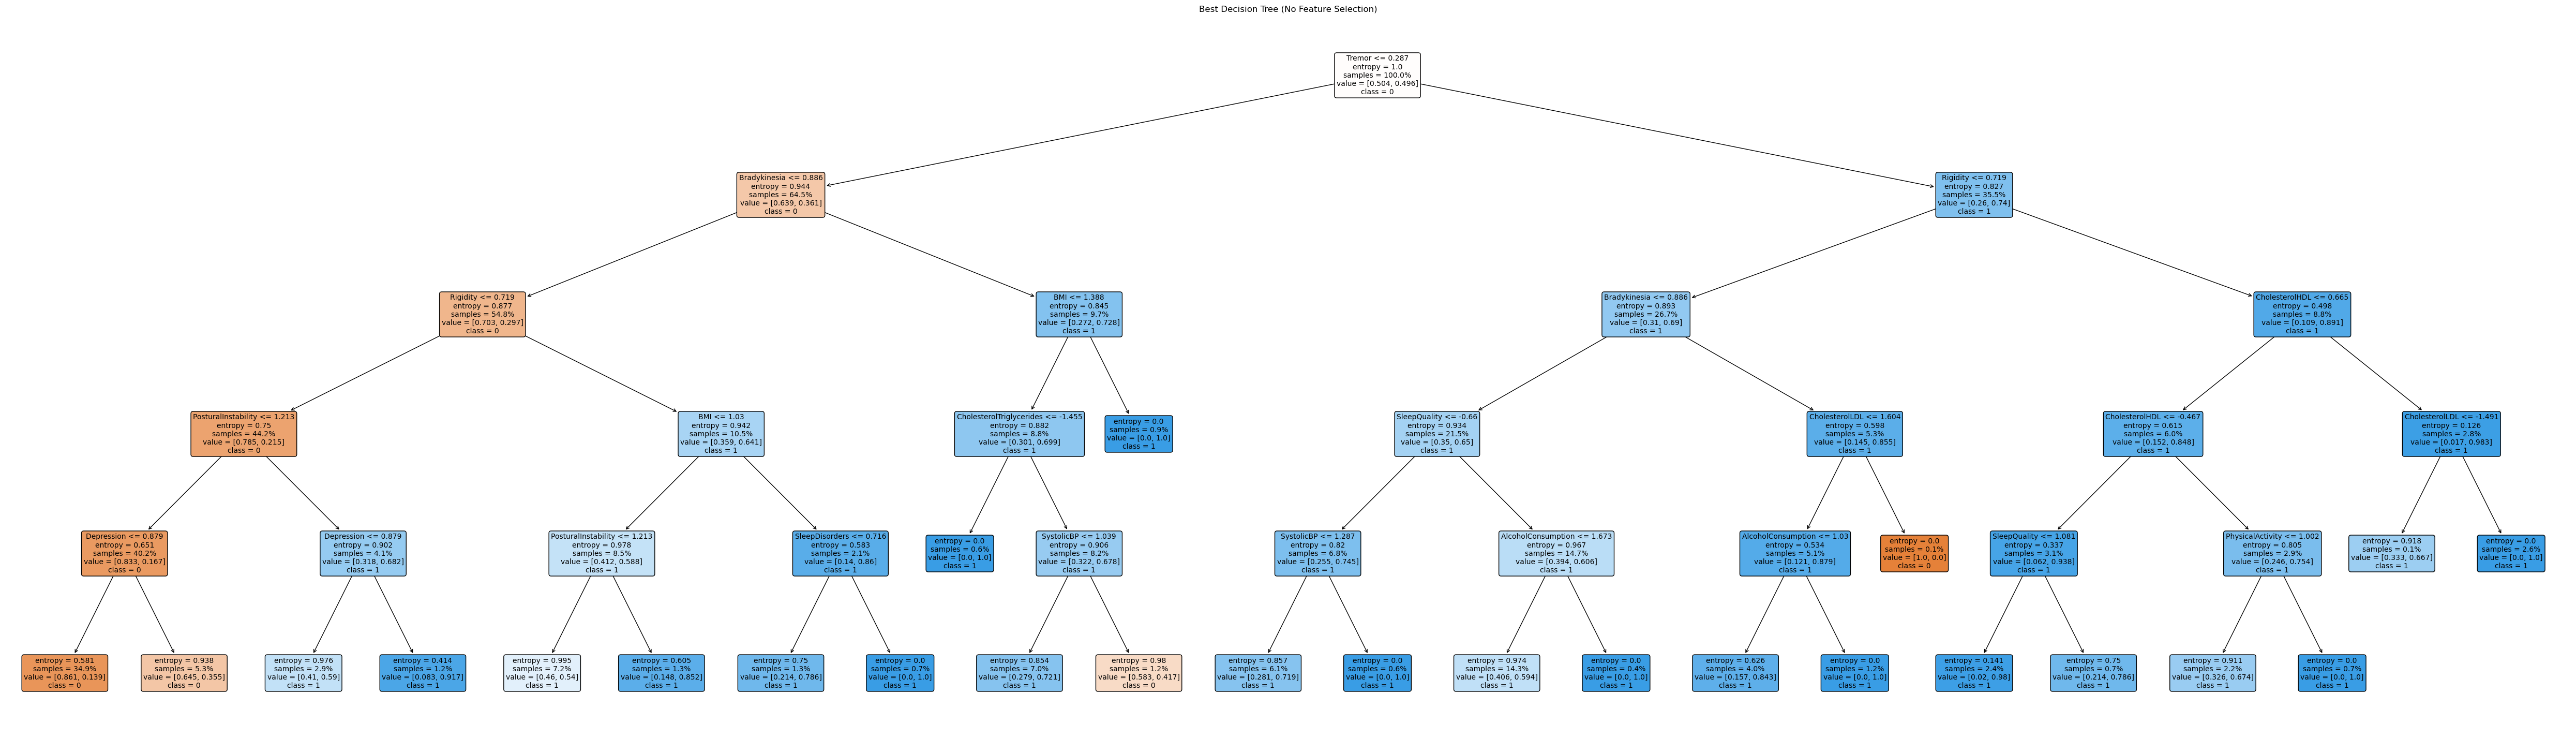

In [52]:
#Show Tree With No Feature Selection Applied
plt.figure(figsize=(64, 18))
plot_tree(dtree_b.best_estimator_, feature_names=feature_names, class_names=["0", "1"], filled=True, rounded=True, proportion=True, fontsize=10)
plt.title("Best Decision Tree (No Feature Selection)")
plt.show()

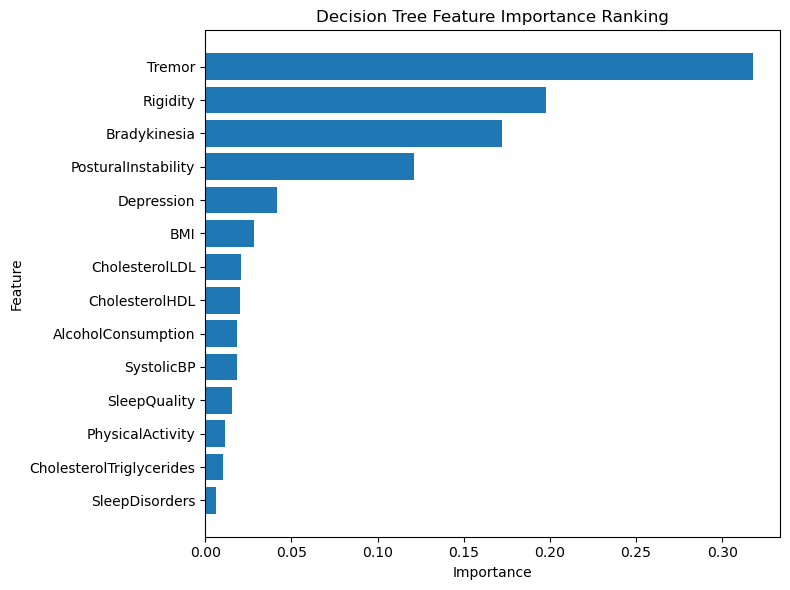

In [53]:
#Show Most Important Features From Full Tree
dtree_b_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": dtree_b.best_estimator_.feature_importances_
})
dtree_b_imp = dtree_b_imp[dtree_b_imp["Importance"] > 0]
dtree_b_imp = dtree_b_imp.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(dtree_b_imp["Feature"], dtree_b_imp["Importance"])
plt.title("Decision Tree Feature Importance Ranking")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The above are features the tree has determined are most important; they mostly agree with the logistic regression features. Like logistic regression, the decisiont tree model attributes the most importance to clinical symptoms. Interestingly, age, which had a small but notable importance in the logistic regression model, was attributed an importance of zero by the decision tree model found via gridsearchcv. Importance values of 0 are not shown on this visualization.

**Fourth Model Implementation - Random Forest**

In [56]:
#Fit Model (GrisSearchCV took ages with this so these hyperparameters were chosen arbitrarily

rf = RandomForestClassifier(random_state=42, n_estimators=200,max_depth=15,max_features='sqrt')
rf.fit(x_train_s, y_train)

rf_b = RandomForestClassifier(random_state=42, n_estimators=200,max_depth=15,max_features='sqrt')
rf_b.fit(x_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

In [57]:
#Make Predictions
rf_pred = rf.predict(x_test_s)
rf_b_pred = rf_b.predict(x_test)

**Fourth Model Evaluation - Random Forest**

With Feature Selection:
Accuracy: 0.7337164750957854
Precision: 0.7220338983050848
Recall: 0.7888888888888889
F1 Score: 0.7539823008849558


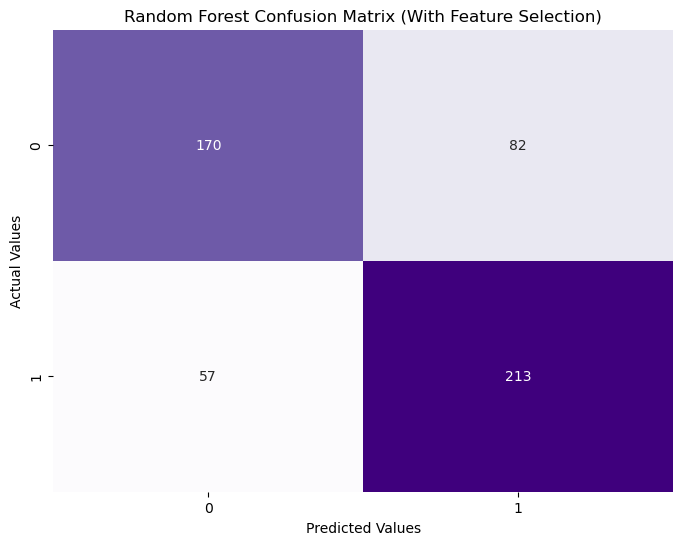


Without Feature Selection:
Accuracy: 0.7605363984674329
Precision: 0.7441077441077442
Recall: 0.8185185185185185
F1 Score: 0.7795414462081128


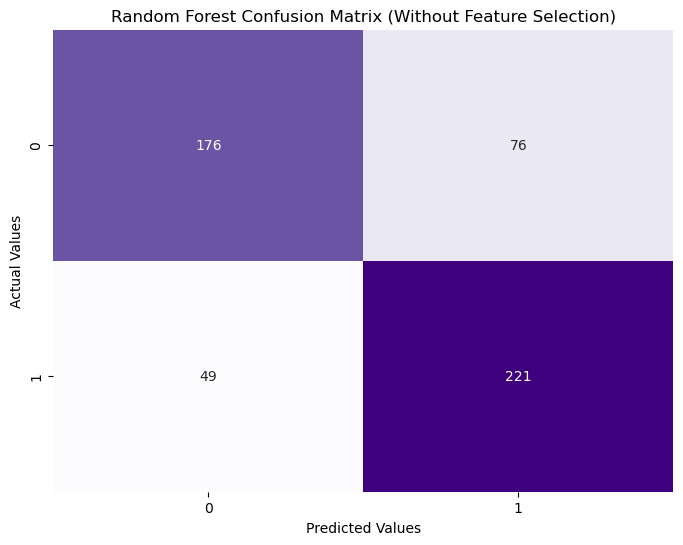

In [59]:
# With Feature Selection
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
print("With Feature Selection:")
print("Accuracy: " + str(rf_accuracy))
print("Precision: " + str(rf_precision))
print("Recall: " + str(rf_recall))
print("F1 Score: " + str(rf_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(rf_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest Confusion Matrix (With Feature Selection)')
plt.show()

# Without Feature Selection
rf_b_accuracy = accuracy_score(y_test, rf_b_pred)
rf_b_precision = precision_score(y_test, rf_b_pred)
rf_b_recall = recall_score(y_test, rf_b_pred)
rf_b_f1 = f1_score(y_test, rf_b_pred)
rf_b_confusion_matrix = confusion_matrix(y_test, rf_b_pred)
print("\nWithout Feature Selection:")
print("Accuracy: " + str(rf_b_accuracy))
print("Precision: " + str(rf_b_precision))
print("Recall: " + str(rf_b_recall))
print("F1 Score: " + str(rf_b_f1))
plt.figure(figsize=(8, 6))
sns.heatmap(rf_b_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest Confusion Matrix (Without Feature Selection)')
plt.show()

**Fourth Model Visualization - Random Forest - TODO**

TODOTODOTODO

**Neural Network Sandbox, something is wrong here lol**

In [63]:
#TRY IMPLEMENTING THIS W/ KERAS
network = MLPClassifier(hidden_layer_sizes=(30, 20), activation='relu', solver='sgd', max_iter=3000, random_state=222)
network.fit(x_train_s, y_train)

MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=3000, random_state=222,
              solver='sgd')

In [64]:
network_pred = network.predict(x_test_s)

With Feature Selection:
Accuracy: 0.7241379310344828
Precision: 0.7202797202797203
Recall: 0.762962962962963
F1 Score: 0.7410071942446043


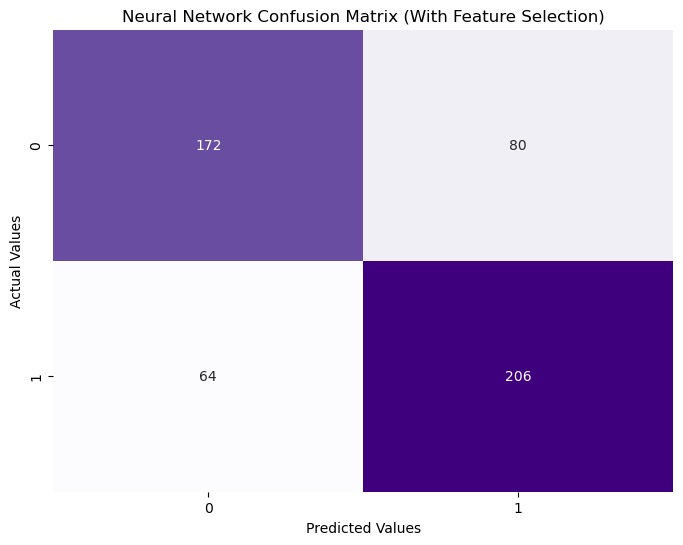

In [65]:
network_accuracy = accuracy_score(y_test, network_pred)
network_precision = precision_score(y_test, network_pred)
network_recall = recall_score(y_test, network_pred)
network_f1 = f1_score(y_test, network_pred)
network_confusion_matrix = confusion_matrix(y_test, network_pred)

print("With Feature Selection:")
print("Accuracy: " + str(network_accuracy))
print("Precision: " + str(network_precision))
print("Recall: " + str(network_recall))
print("F1 Score: " + str(network_f1))

plt.figure(figsize=(8, 6))
sns.heatmap(network_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Neural Network Confusion Matrix (With Feature Selection)')
plt.show()

**Final Ensemble w/ Stacking just for fun**

In [67]:
models = [
    ('svm', svm_b),
    ('logreg', logreg),
    ('dtree', dtree),
    ('rf', rf),
    ('nn', network)
]
metamodel = LogisticRegression()

stacking = StackingClassifier(estimators=models, final_estimator=metamodel, passthrough=False)
stacking.fit(x_train_s, y_train)

StackingClassifier(estimators=[('svm',
                                GridSearchCV(cv=5,
                                             estimator=SVC(random_state=42),
                                             param_grid={'C': [0.1, 1, 10],
                                                         'gamma': [0.01, 0.1, 1,
                                                                   10]},
                                             scoring='f1')),
                               ('logreg', LogisticRegression(random_state=42)),
                               ('dtree',
                                GridSearchCV(cv=5,
                                             estimator=DecisionTreeClassifier(random_state=42),
                                             param_grid={'criterion': ['gini',
                                                                       'entropy'],
                                                         'max_depth': [5, 10,
                                                                       15,
                                                                       None],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              4],
                                                         'min_samples_split': [5,
                                                                               10]},
                                             scoring='f1')),
                               ('rf',
                                RandomForestClassifier(max_depth=15,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('nn',
                                MLPClassifier(hidden_layer_sizes=(30, 20),
                                              max_iter=3000, random_state=222,
                                              solver='sgd'))],
                   final_estimator=LogisticRegression())

In [68]:
stacking_pred = stacking.predict(x_test_s)

Stacking:
Accuracy: 0.7413793103448276
Precision: 0.7319587628865979
Recall: 0.7888888888888889
F1 Score: 0.7593582887700535


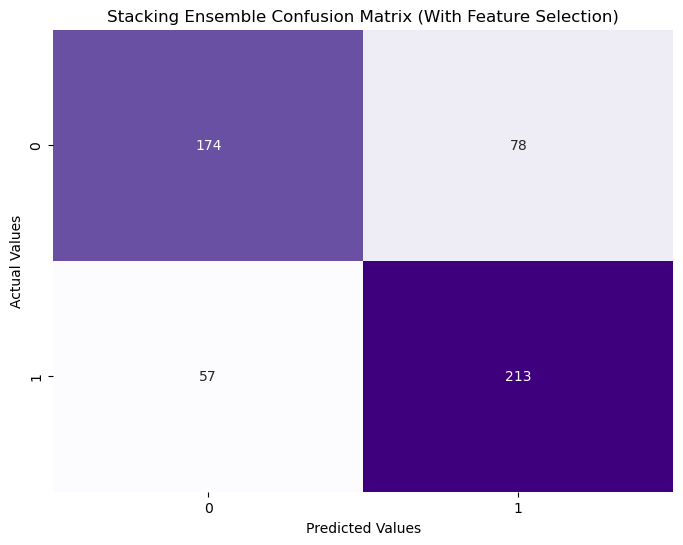

In [69]:
stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_precision = precision_score(y_test, stacking_pred)
stacking_recall = recall_score(y_test, stacking_pred)
stacking_f1 = f1_score(y_test, stacking_pred)
stacking_confusion_matrix = confusion_matrix(y_test, stacking_pred)

print("Stacking:")
print("Accuracy: " + str(stacking_accuracy))
print("Precision: " + str(stacking_precision))
print("Recall: " + str(stacking_recall))
print("F1 Score: " + str(stacking_f1))

plt.figure(figsize=(8, 6))
sns.heatmap(stacking_confusion_matrix, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Stacking Ensemble Confusion Matrix (With Feature Selection)')
plt.show()

In [70]:
#1) Check other people's work on the dataset to see results and data preprocessing to compare how we are doing
#2) Spend some time on data preprocessing to check if we are missing anything
#3) MORE VISUALIZATIONS (!!!!)
#4) Try RFE Feature Selection 
#5) Try SVM with linear kernel, knn
#6) Import keras and implement neural network (1-2 HL) and deep neural network (4-6 HL)
#7) Try bagging and boosting to see if they give better results

#Make a table w/ ML model results & another w/ensemble results
#Compare model metrics once we have table

In [71]:
# Compare other work on the dataset to see results
# Link to other person's work: https://www.kaggle.com/code/medhamanojpanik/parkinson-disease-prediction/notebook


In [72]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(pk_features, pk_target, test_size=0.2, random_state=42)

# Bagging 
bagging_model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)


y_pred_bagging = bagging_model.predict(X_test)
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)

# AdaBoost with SAMME Algorithm 
adaboost_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42,
    algorithm='SAMME'  # Use the SAMME algorithm instead of SAMME.R
)
adaboost_model.fit(X_train, y_train)
y_pred_adaboost = adaboost_model.predict(X_test)
adaboost_accuracy = accuracy_score(y_test, y_pred_adaboost)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)

print(f"Bagging Accuracy: {bagging_accuracy}")
print(f"AdaBoost Accuracy: {adaboost_accuracy}")
print(f"Gradient Boosting Accuracy: {gb_accuracy}")

Bagging Accuracy: 0.6959619952494062
AdaBoost Accuracy: 0.6935866983372921
Gradient Boosting Accuracy: 0.6864608076009501


Bagging and Boosting 

In [74]:
# Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical


# Split data
X_train, X_test, y_train, y_test = train_test_split(pk_features, pk_target, test_size=0.2, random_state=42)

# Convert y to one-hot encoding if it's categorical
if len(np.unique(y_train)) > 2:  # Multiclass case
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

# NN with 1-2 Hidden Layers
simple_nn = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'), # First hidden layer
    Dense(16, activation='relu'),                             # Second hidden layer
    Dense(y_train.shape[1] if y_train.ndim > 1 else 1, activation='softmax' if y_train.ndim > 1 else 'sigmoid') # Output layer
])
    
simple_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy' if y_train.ndim == 1 else 'categorical_crossentropy', metrics=['accuracy'])
simple_nn.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Prediction and evaluation
y_pred_nn = simple_nn.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1) if y_train.ndim > 1 else (y_pred_nn > 0.5).astype(int)
nn_accuracy = accuracy_score(np.argmax(y_test, axis=1) if y_train.ndim > 1 else y_test, y_pred_nn_classes)

deep_nn = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
    Dense(64, activation='relu'),                              # Second hidden layer
    Dense(32, activation='relu'),                              # Third hidden layer
    Dense(16, activation='relu'),                              # Fourth hidden layer
    Dense(8, activation='relu'),                               # Fifth hidden layer
    Dense(y_train.shape[1] if y_train.ndim > 1 else 1, activation='softmax' if y_train.ndim > 1 else 'sigmoid') # Output layer
])

deep_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy' if y_train.ndim == 1 else 'categorical_crossentropy', metrics=['accuracy'])
deep_nn.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Prediction and evaluation
y_pred_dnn = deep_nn.predict(X_test)
y_pred_dnn_classes = np.argmax(y_pred_dnn, axis=1) if y_train.ndim > 1 else (y_pred_dnn > 0.5).astype(int)
dnn_accuracy = accuracy_score(np.argmax(y_test, axis=1) if y_train.ndim > 1 else y_test, y_pred_dnn_classes)

print(f"Neural Network Accuracy (1-2 HL): {nn_accuracy}")
print(f"Deep Neural Network Accuracy (4-6 HL): {dnn_accuracy}")

ModuleNotFoundError: No module named 'keras'